# Data Cleaning

In [1]:
# initialize spark session
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
import warnings
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('iteration4').getOrCreate()

In [2]:
# Using this syntax, we can drop any row with missing data. Three rows are dropped.
import pyspark.sql.functions as func
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import dayofmonth,month,hour,year,format_number
from pyspark.sql.types import (StructField, StructType,
                               TimestampType, IntegerType, FloatType)

In [3]:
# Import the relevant Python libraries.
import numpy as np
import pandas as pd 
# Transform PySpark data frame `df` to Python data frame `data`
#data = df.toPandas()
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams

In [4]:
from pyspark.ml.feature import VectorAssembler
# Construct Data
from pyspark.ml.feature import OneHotEncoder
# one hot encode: convert numbers into a vector
from pyspark.ml import Pipeline

In [5]:
df = spark.read.csv('cardio_train.csv', header=True, inferSchema=True)

In [6]:
df.describe('age', 'gender','height', 'weight', 'ap_hi', 'ap_lo').show()

+-------+------------------+-------------------+------------------+------------------+-----------------+------------------+
|summary|               age|             gender|            height|            weight|            ap_hi|             ap_lo|
+-------+------------------+-------------------+------------------+------------------+-----------------+------------------+
|  count|             70000|              70000|             70000|             70000|            70000|             70000|
|   mean|19468.865814285713| 1.3495714285714286|164.35922857142856|          74.20569|128.8172857142857| 96.63041428571428|
| stddev| 2467.251667241397|0.47683801558286265| 8.210126364538075|14.395756678511347|154.0114194560919|188.47253029638918|
|    min|             10798|                  1|                55|              10.0|             -150|               -70|
|    max|             23713|                  2|               250|             200.0|            16020|             11000|
+-------

In [7]:
df.filter( (df['ap_hi'] <360) & (df['ap_lo'] < 360) )

DataFrame[id: int, age: int, gender: int, height: int, weight: double, ap_hi: int, ap_lo: int, cholesterol: int, gluc: int, smoke: int, alco: int, active: int, cardio: int]

In [8]:
df_outlier = df

drop_list = ['ap_hi', 'ap_lo']

df_outlier = df_outlier.select([column for column in df.columns if column in drop_list])

df_outlier.printSchema()

bounds = {
    c: dict(
        zip(["q1", "q3"], df_outlier.approxQuantile(c, [0.025, 0.975], 0))
    )
    for c in df_outlier.columns
}

for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1']# - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3']# + (iqr * 1.5)
    

for i in df_outlier.schema.names:
    print(i + ": " + str(bounds[i]))
    print("")

root
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)

ap_hi: {'q1': 100.0, 'q3': 170.0, 'lower': 100.0, 'upper': 170.0}

ap_lo: {'q1': 60.0, 'q3': 100.0, 'lower': 60.0, 'upper': 100.0}



In [9]:
df.count()

70000

In [10]:
df = df.filter( (df['ap_hi'] > df['ap_lo']) )

In [11]:
print('Number of Rows: ', df.count())

print(df)

Number of Rows:  68764
DataFrame[id: int, age: int, gender: int, height: int, weight: double, ap_hi: int, ap_lo: int, cholesterol: int, gluc: int, smoke: int, alco: int, active: int, cardio: int]


In [12]:
df.drop_duplicates().count()

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 1035, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 883, in send_command
    response = connection.send_command(command)
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 1040, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:46808)
Traceback (most recent call last):
  File "/home

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:46808)
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-d2dd81a2fd6c>", line 1, in <module>
    df.drop_duplicates().count()
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/pyspark/sql/dataframe.py", line 380, in count
    return int(self._jdf.count())
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 1133, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/protocol.py", line 327, in get_return_value
    format(target_id, ".", name))
py4

Py4JError: An error occurred while calling o98.count

In [13]:
df.count()

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:46808)
Traceback (most recent call last):
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 827, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 963, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:46808)

In [14]:
data = df.toPandas()

corr = data.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:46808)
Traceback (most recent call last):
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 827, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 963, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:46808)

(135.0, 195.0)

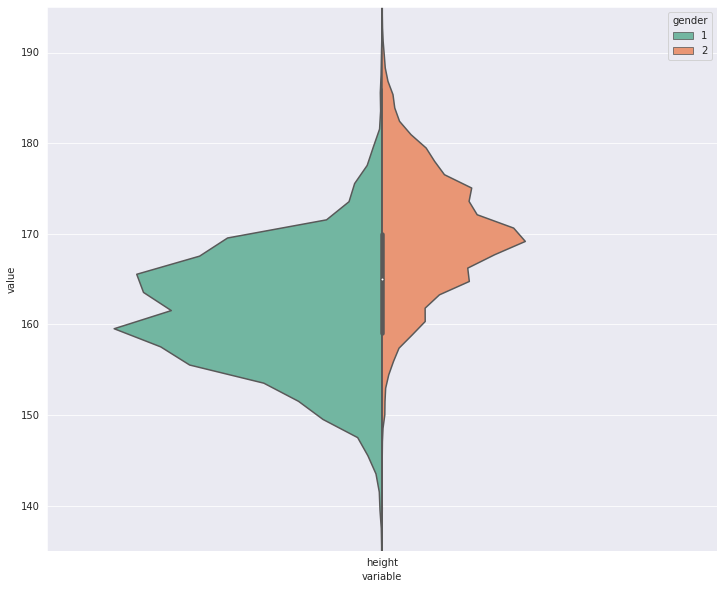

In [97]:
warnings.filterwarnings("ignore")
#data = df.toPandas()
data_melt = pd.melt(frame=data, value_vars=['height'], id_vars=['gender'])
plt.figure(figsize=(12, 10))
ax = sns.violinplot(
    x='variable', 
    y='value', 
    hue='gender', 
    split=True, 
    data=data_melt, 
    scale='count',
    scale_hue=False,
    palette="Set2");

plt.ylim(135, 195)

In [98]:
# add variable
df = df.withColumn('BMI',func.round(df['weight']/((df['height']/100)**2)))

In [99]:
print(df)
df.show(5)

DataFrame[id: int, age: int, gender: int, height: int, weight: double, ap_hi: int, ap_lo: int, cholesterol: int, gluc: int, smoke: int, alco: int, active: int, cardio: int, BMI: double]
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+----+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio| BMI|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+----+
|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|22.0|
|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|35.0|
|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|24.0|
|  3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|29.0|
|  4|17474|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|23.0|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------

In [100]:
df = df.withColumn('years',func.round(df['age']/365))

In [101]:
df_s = df.drop('height', 'weight', 'id', 'age')

In [102]:
df_s.printSchema()

root
 |-- gender: integer (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- years: double (nullable = true)



In [103]:
df_s.show(5)

+------+-----+-----+-----------+----+-----+----+------+------+----+-----+
|gender|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio| BMI|years|
+------+-----+-----+-----------+----+-----+----+------+------+----+-----+
|     2|  110|   80|          1|   1|    0|   0|     1|     0|22.0| 50.0|
|     1|  140|   90|          3|   1|    0|   0|     1|     1|35.0| 55.0|
|     1|  130|   70|          3|   1|    0|   0|     0|     1|24.0| 52.0|
|     2|  150|  100|          1|   1|    0|   0|     1|     1|29.0| 48.0|
|     1|  100|   60|          1|   1|    0|   0|     0|     0|23.0| 48.0|
+------+-----+-----+-----------+----+-----+----+------+------+----+-----+
only showing top 5 rows



(68764, 11)


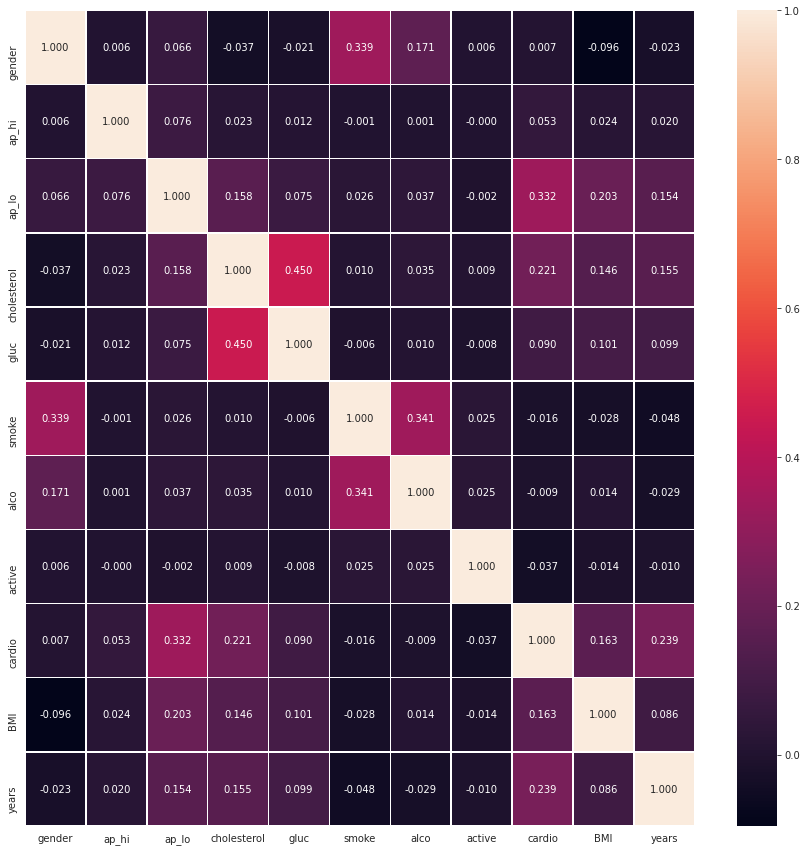

In [104]:
data = df_s.toPandas()
corr = data.corr()
f, ax = plt.subplots(figsize = (15,15))
sns.heatmap(corr, annot=True, fmt=".3f", linewidths=0.5, ax=ax)

print(data.shape)

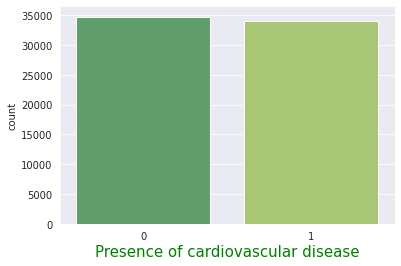

In [105]:
data = df_s.toPandas()

sns.set_style('darkgrid')
sns.countplot(data.cardio,palette='summer')
plt.xlabel('Presence of cardiovascular disease',fontdict={'fontsize': 15,'color':'Green'},labelpad=3);

# Data Transform

In [106]:
df_outlier = df_s

do_list = ['years']

df_outlier = df_outlier.select([column for column in df_s.columns if column in do_list])

df_outlier.printSchema()

bounds = {
    c: dict(
        zip(["q1", "q3"], df_outlier.approxQuantile(c, [0.001, 0.999], 0))
    )
    for c in df_outlier.columns
}

for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1']# - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3']# + (iqr * 1.5)
    

for i in df_outlier.schema.names:
    print(i + ": " + str(bounds[i]))
    print("")

root
 |-- years: double (nullable = true)

years: {'q1': 39.0, 'q3': 65.0, 'lower': 39.0, 'upper': 65.0}



### Data Construction

In [107]:
genderEncoder = OneHotEncoder(inputCol='gender', outputCol='genderVec')
cholesterolEncoder = OneHotEncoder(inputCol='cholesterol', outputCol='cholesterolVec')
glucEncoder = OneHotEncoder(inputCol='gluc', outputCol='glucVec')

In [108]:
df_s.printSchema()

root
 |-- gender: integer (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- years: double (nullable = true)



In [109]:
print((df_s.count(), len(df_s.columns)))

(68764, 11)


In [110]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = [genderEncoder, cholesterolEncoder, glucEncoder])

# constructed data frame
df_c = pipeline.fit(df_s).transform(df_s)

df_c.printSchema()

root
 |-- gender: integer (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- years: double (nullable = true)
 |-- genderVec: vector (nullable = true)
 |-- cholesterolVec: vector (nullable = true)
 |-- glucVec: vector (nullable = true)



In [111]:
df_r = df_c.drop('gluc', 'gender', 'cholesterol')
df_r.printSchema()

root
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- years: double (nullable = true)
 |-- genderVec: vector (nullable = true)
 |-- cholesterolVec: vector (nullable = true)
 |-- glucVec: vector (nullable = true)



In [112]:
from pyspark.ml.feature import VectorAssembler

# Project the data
featuresCol = df_r.drop('cardio').columns

# assemble features into a vector for modeling
assembler = VectorAssembler(inputCols = featuresCol, outputCol = 'features')
df_projected = assembler.transform(df_r)

In [113]:
df_projected.printSchema()

root
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- years: double (nullable = true)
 |-- genderVec: vector (nullable = true)
 |-- cholesterolVec: vector (nullable = true)
 |-- glucVec: vector (nullable = true)
 |-- features: vector (nullable = true)



# Data Formatting

In [114]:
df_final = df_projected.select('cardio', 'features')
df_final.show(20)
print(df_final)

+------+--------------------+
|cardio|            features|
+------+--------------------+
|     0|(15,[0,1,4,5,6,10...|
|     1|(15,[0,1,4,5,6,8,...|
|     1|(15,[0,1,5,6,8,13...|
|     1|(15,[0,1,4,5,6,10...|
|     0|(15,[0,1,5,6,8,10...|
|     0|(15,[0,1,5,6,8,11...|
|     0|(15,[0,1,4,5,6,8,...|
|     1|(15,[0,1,4,5,6],[...|
|     0|(15,[0,1,4,5,6,8,...|
|     0|(15,[0,1,5,6,8,10...|
|     0|(15,[0,1,4,5,6,8,...|
|     0|(15,[0,1,4,5,6,10...|
|     0|(15,[0,1,5,6,10,1...|
|     0|(15,[0,1,4,5,6,8,...|
|     0|[130.0,90.0,1.0,1...|
|     1|(15,[0,1,5,6,10,1...|
|     0|(15,[0,1,5,6,8,10...|
|     0|(15,[0,1,4,5,6,8,...|
|     0|(15,[0,1,5,6,8,10...|
|     0|(15,[0,1,2,4,5,6,...|
+------+--------------------+
only showing top 20 rows

DataFrame[cardio: int, features: vector]


### Parameter Setting

In [115]:
#splite data set
train, test = df_final.randomSplit([0.7, 0.3], seed = 2018)

#create a sample for model test
sample, x = df_final.randomSplit([0.3, 0.7])

print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 48033
Test Dataset Count: 20731


In [116]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#  Model Selection

In [117]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier

# Data Mining

## Logistic Regression

### Trainning

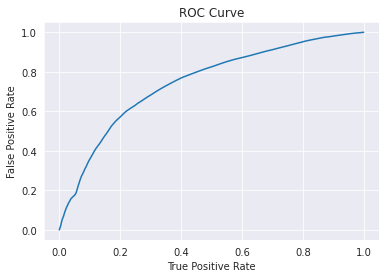

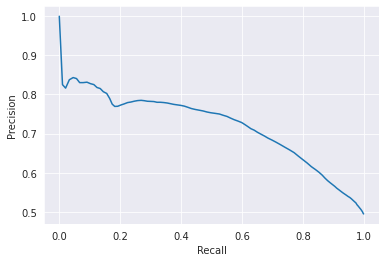

Training set areaUnderROC: 0.7451939644961656


In [36]:
final_model = LogisticRegression(featuresCol = 'features', labelCol = 'cardio', maxIter=10)
fit_final = final_model.fit(train)
trainingSummary = fit_final.summary
lrROC = trainingSummary.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [37]:
trainingSummary.predictions.show()

+------+--------------------+--------------------+--------------------+----------+
|cardio|            features|       rawPrediction|         probability|prediction|
+------+--------------------+--------------------+--------------------+----------+
|   0.0|(15,[0,1,2,3,4,5,...|[-0.9213525661204...|[0.28468237980680...|       1.0|
|   0.0|(15,[0,1,2,3,4,5,...|[-1.1755223926259...|[0.23585823684352...|       1.0|
|   0.0|(15,[0,1,2,3,4,5,...|[-1.1176207033740...|[0.24645288530236...|       1.0|
|   0.0|(15,[0,1,2,3,4,5,...|[-1.3375938959838...|[0.20790601995607...|       1.0|
|   0.0|(15,[0,1,2,3,4,5,...|[-1.1331546548795...|[0.24357939049314...|       1.0|
|   0.0|(15,[0,1,2,3,4,5,...|[-1.4394313166216...|[0.19163342788790...|       1.0|
|   0.0|(15,[0,1,2,3,4,5,...|[-1.4064039437873...|[0.19680186847535...|       1.0|
|   0.0|(15,[0,1,2,3,4,5,...|[-1.4742658312112...|[0.18629509435345...|       1.0|
|   0.0|(15,[0,1,2,3,4,5,...|[-1.6603569999417...|[0.15971407977010...|       1.0|
|   

### Prediction

In [38]:
predictions_and_labels = fit_final.evaluate(test)
predictions_and_labels.predictions.show()

+------+--------------------+--------------------+--------------------+----------+
|cardio|            features|       rawPrediction|         probability|prediction|
+------+--------------------+--------------------+--------------------+----------+
|     0|(15,[0,1,2,3,4,5,...|[-1.0983201402900...|[0.25005478182160...|       1.0|
|     0|(15,[0,1,2,3,4,5,...|[-1.1283314112208...|[0.24446916449154...|       1.0|
|     0|(15,[0,1,2,3,4,5,...|[1.65671260602876...|[0.83979621579190...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[1.40351438987982...|[0.80274097695961...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[1.14028847218614...|[0.75773259890724...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[0.85218823807490...|[0.70102597378980...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[0.82309537620754...|[0.69489300722692...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[0.41231517069684...|[0.60164288321187...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[-1.4376268516641...|[0.19191311320898...|       1.0|
|   

### Evaluation

In [39]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='cardio')
my_final_roc = evaluator.evaluate(predictions_and_labels.predictions)

my_final_roc

#lrPreds = predictions_and_labels.transform(test)
#lrPreds.select('ap_hi', 'ap_lo', 
               'years', 'rawPrediction', 'prediction', 'probability').show(10)

0.6841703193849155

In [40]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='cardio',
                                            metricName='accuracy')
accuracy = evaluator.evaluate(predictions_and_labels.predictions)
accuracy

0.6853986783078482

### Interpretation

## Decision Tree

### Training

In [81]:


#evaluator = BinaryClassificationEvaluator()

#dtROC = evaluator.evaluate(predictions_and_labels_dt, {evaluator.metricName: "areaUnderROC"})

#print("Test Area Under ROC decision tree max depth 3: " + str(dtROC))

#dtPreds = dtModel.transform(test)

#predictions_and_labels_dt = fit_final_dt.evaluate(test)


#dtEval = BinaryClassificationEvaluator()




#dtROC = dtEval.evaluate(dtPreds, {dtEval.metricName: "areaUnderROC"})


final_model_dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'cardio', maxDepth = 10)

fit_final_dt = final_model_dt.fit(train)






#predictions_and_labels_dt.predictions.show()
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='cardio')

my_final_roc_dt = evaluator.evaluate(predictions_and_labels_dt.predictions)
my_final_roc_dt





#dtEval = BinaryClassificationEvaluator()







AttributeError: 'DataFrame' object has no attribute 'predictions'

In [ ]:

#trainingSummary_dt = fit_final_dt.summary
#lrROC = trainingSummary_dt.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

pr = trainingSummary_dt.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary_dt.areaUnderROC))

trainingSummary_dt.predictions.show()



### Prediction

In [46]:
predictions_and_labels_dt = fit_final_dt.evaluate(test)
predictions_and_labels_dt.show()

+------+--------------------+--------------------+--------------------+----------+
|cardio|            features|       rawPrediction|         probability|prediction|
+------+--------------------+--------------------+--------------------+----------+
|     0|(15,[0,1,2,3,4,5,...|[-1.0983201402900...|[0.25005478182160...|       1.0|
|     0|(15,[0,1,2,3,4,5,...|[-1.1283314112208...|[0.24446916449154...|       1.0|
|     0|(15,[0,1,2,3,4,5,...|[1.65671260602876...|[0.83979621579190...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[1.40351438987982...|[0.80274097695961...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[1.14028847218614...|[0.75773259890724...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[0.85218823807490...|[0.70102597378980...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[0.82309537620754...|[0.69489300722692...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[0.41231517069684...|[0.60164288321187...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[-1.4376268516641...|[0.19191311320898...|       1.0|
|   

### Evaluation

In [51]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='cardio')
my_final_roc_dt = evaluator.evaluate(predictions_and_labels_dt.predictions)
my_final_roc_dt

0.6841703193849155

In [52]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='cardio',
                                            metricName='accuracy')
accuracy_dt = evaluator.evaluate(predictions_and_labels_dt.predictions)
accuracy_dt

0.6853986783078482

### Feature Importance

In [94]:
fit_final_dt.featureImportances

AttributeError: 'LogisticRegressionModel' object has no attribute 'featureImportances'

### Random Forest 10

### Training

In [78]:
final_model_rf_10 = RandomForestClassifier(featuresCol = 'features', labelCol = 'cardio', numTrees = 10, maxDepth = 10)

fit_final_rf_10 = final_model.fit(train)
trainingSummary_rf_10 = fit_final_rf_10.summary
lrROC = trainingSummary_rf_10.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

NameError: name 'final_model' is not defined

In [71]:
trainingSummary_rf_10.predictions.show()

+------+--------------------+--------------------+--------------------+----------+
|cardio|            features|       rawPrediction|         probability|prediction|
+------+--------------------+--------------------+--------------------+----------+
|   0.0|(15,[0,1,2,3,4,5,...|[-0.9213525661204...|[0.28468237980680...|       1.0|
|   0.0|(15,[0,1,2,3,4,5,...|[-1.1755223926259...|[0.23585823684352...|       1.0|
|   0.0|(15,[0,1,2,3,4,5,...|[-1.1176207033740...|[0.24645288530236...|       1.0|
|   0.0|(15,[0,1,2,3,4,5,...|[-1.3375938959838...|[0.20790601995607...|       1.0|
|   0.0|(15,[0,1,2,3,4,5,...|[-1.1331546548795...|[0.24357939049314...|       1.0|
|   0.0|(15,[0,1,2,3,4,5,...|[-1.4394313166216...|[0.19163342788790...|       1.0|
|   0.0|(15,[0,1,2,3,4,5,...|[-1.4064039437873...|[0.19680186847535...|       1.0|
|   0.0|(15,[0,1,2,3,4,5,...|[-1.4742658312112...|[0.18629509435345...|       1.0|
|   0.0|(15,[0,1,2,3,4,5,...|[-1.6603569999417...|[0.15971407977010...|       1.0|
|   

### Prediction

In [77]:
predictions_and_labels_rf_10 = fit_final_dt.evaluate(test)
predictions_and_labels_rf_10.predictions.show()

AttributeError: 'DecisionTreeClassificationModel' object has no attribute 'evaluate'

### Evaluation

In [76]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='cardio')
my_final_roc_rf_10 = evaluator.evaluate(predictions_and_labels_rf_10.predictions)
my_final_roc_rf_10



lrROC = predictions_and_labels_rf_10.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

pr = predictions_and_labels_rf_10.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

print('Training set areaUnderROC: ' + str(predictions_and_labels_rf_10.areaUnderROC))

NameError: name 'predictions_and_labels_rf_10' is not defined

In [88]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='cardio',
                                            metricName='accuracy')
accuracy_rf_10 = evaluator.evaluate(predictions_and_labels_rf_10.predictions)
accuracy_rf_10

0.6853986783078482

###  Random Forest 50 

### Training

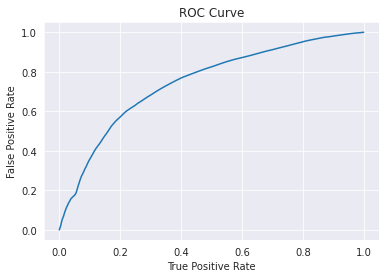

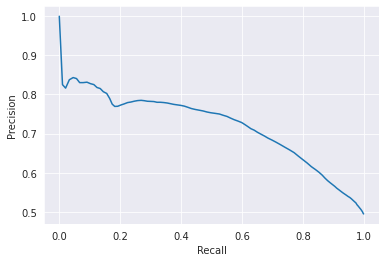

Training set areaUnderROC: 0.7451939644961656


In [59]:
final_model_rf_50 = RandomForestClassifier(featuresCol = 'features', labelCol = 'cardio', numTrees = 50, maxDepth = 10)
fit_final_rf_50 = final_model.fit(train)
trainingSummary_rf_50 = fit_final_rf_10.summary
lrROC = trainingSummary_rf_50.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### Prediction

In [73]:
predictions_and_labels_rf_50 = fit_final_dt.evaluate(test)
predictions_and_labels_rf_50.predictions.show()

+------+--------------------+--------------------+--------------------+----------+
|cardio|            features|       rawPrediction|         probability|prediction|
+------+--------------------+--------------------+--------------------+----------+
|     0|(15,[0,1,2,3,4,5,...|[-1.0983201402900...|[0.25005478182160...|       1.0|
|     0|(15,[0,1,2,3,4,5,...|[-1.1283314112208...|[0.24446916449154...|       1.0|
|     0|(15,[0,1,2,3,4,5,...|[1.65671260602876...|[0.83979621579190...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[1.40351438987982...|[0.80274097695961...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[1.14028847218614...|[0.75773259890724...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[0.85218823807490...|[0.70102597378980...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[0.82309537620754...|[0.69489300722692...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[0.41231517069684...|[0.60164288321187...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[-1.4376268516641...|[0.19191311320898...|       1.0|
|   

### Evaluation

In [82]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='cardio')
my_final_roc_rf_50 = evaluator.evaluate(predictions_and_labels_rf_50.predictions)
my_final_roc_rf_50

0.6841703193849155

In [84]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='cardio',
                                            metricName='accuracy')
accuracy_rf_50 = evaluator.evaluate(predictions_and_labels_rf_50.predictions)
accuracy_rf_50

0.6853986783078482

### Random Forest 100

### Training

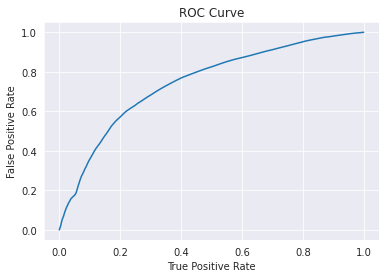

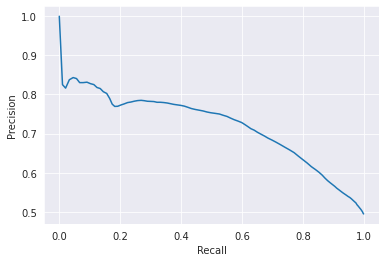

Training set areaUnderROC: 0.7451939644961656


In [60]:
final_model_rf_100 = RandomForestClassifier(featuresCol = 'features', labelCol = 'cardio', numTrees = 100, maxDepth = 10)

fit_final_rf_100 = final_model.fit(train)
trainingSummary_rf_100 = fit_final_rf_10.summary
lrROC = trainingSummary_rf_100.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### Prediction

In [79]:
predictions_and_labels_rf_100 = fit_final_rf_100.evaluate(test)
predictions_and_labels_rf_100.predictions.show()

+------+--------------------+--------------------+--------------------+----------+
|cardio|            features|       rawPrediction|         probability|prediction|
+------+--------------------+--------------------+--------------------+----------+
|     0|(15,[0,1,2,3,4,5,...|[-1.0983201402900...|[0.25005478182160...|       1.0|
|     0|(15,[0,1,2,3,4,5,...|[-1.1283314112208...|[0.24446916449154...|       1.0|
|     0|(15,[0,1,2,3,4,5,...|[1.65671260602876...|[0.83979621579190...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[1.40351438987982...|[0.80274097695961...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[1.14028847218614...|[0.75773259890724...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[0.85218823807490...|[0.70102597378980...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[0.82309537620754...|[0.69489300722692...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[0.41231517069684...|[0.60164288321187...|       0.0|
|     0|(15,[0,1,2,3,4,5,...|[-1.4376268516641...|[0.19191311320898...|       1.0|
|   

### Evaluation

In [83]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='cardio')
my_final_roc_rf_100 = evaluator.evaluate(predictions_and_labels_rf_100.predictions)
my_final_roc_rf_100

0.6841703193849155

In [85]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='cardio',
                                            metricName='accuracy')
accuracy_rf_100 = evaluator.evaluate(predictions_and_labels_rf_100.predictions)
accuracy_rf_100

0.6853986783078482